In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np           
import xml.etree.ElementTree as Et
from PIL import Image as im
import math 
from sklearn.linear_model import Ridge
from utils import *
import pandas as pd
import matplotlib.pyplot as plt



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
from PIL import Image as im
import time
import copy
from tqdm import tqdm
from torch.nn.functional import one_hot





# obj_class =[]
# for e,i in enumerate(os.listdir( annot_path)):
#     xml =  open(os.path.join(annot_path, i), "r")
#     tree = Et.parse(xml)
#     root = tree.getroot()
#     objects = root.findall("object")
#     obj_class = obj_class + [_object.find('name').text for _object in objects ]
#     obj_class = list(set(obj_class))
#     if len(obj_class) == 20:
#         break


obj_class = ['person', 
           'bird', 
           'cat', 
           'cow', 
           'dog',    # 5
           'horse', 
           'sheep', 
           'aeroplane', 
           'bicycle', 
           'boat',   # 10
           'bus', 
           'car', 
           'motorbike', 
           'train', 
           'bottle', 
           'chair',  # 16
           'diningtable', 
           'pottedplant', 
           'sofa', 
           'tvmonitor'
           ]

obj_class = ['background'] + obj_class




c:\Users\20161699\Anaconda3\envs\joowan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# VOC dataset을 selective search한 결과를 폴더에 저장하는 함수

train

In [3]:
data_dir='data2'

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        
    ]),
}

In [5]:
image_dataset={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
#dataloaders_dict={x: DataLoader(image_dataset[x],batch_size=128,shuffle=True,num_workers=4,generator=torch.Generator(device='cuda')) for x in ['train','val']}


dataloaders_dict={'train':DataLoader(image_dataset['train'],batch_size=128,shuffle=True,num_workers=4,generator=torch.Generator(device='cuda')),
                    'val':DataLoader(image_dataset['val'],batch_size=16,shuffle=True,num_workers=4,generator=torch.Generator(device='cuda')) }

In [6]:
image_dataset

{'train': Dataset ImageFolder
     Number of datapoints: 325945
     Root location: data2\train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 10507
     Root location: data2\val
     StandardTransform
 Transform: Compose(
                ToTensor()
            )}

In [7]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass
     

using cuda: NVIDIA GeForce RTX 3080 Ti


In [8]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16=models.vgg16()

for param in vgg16.parameters():
    param.requires_grad=False

vgg16.classifier=nn.Sequential(nn.Flatten(),
                                nn.Linear(in_features=25088,out_features=4096,bias=True),
                                nn.Dropout(0.5),
                                nn.ReLU(inplace=True),
                                
                                nn.Linear(4096,1024,bias=True),
                                nn.Dropout(0.5),
                                nn.ReLU(inplace=True),
                                
                                nn.Linear(1024,21,bias=True)
                                )   

model=vgg16.to(device)
loss_func=nn.MultiLabelMarginLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001 )


In [9]:


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# resnet18=models.resnet18()

# resnet18.classifier=nn.Sequential(nn.Flatten(),
#                                 nn.Linear(in_features=25088,out_features=4096,bias=True),
#                                 nn.Dropout(0.5),
#                                 nn.ReLU(inplace=True),
                                
#                                 nn.Linear(4096,1024,bias=True),
#                                 nn.Dropout(0.5),
#                                 nn.ReLU(inplace=True),
                                
#                                 nn.Linear(1024,21,bias=True)
#                                 )   

# model=resnet18.to(device)
# loss_func=nn.CrossEntropyLoss()
# optimizer=optim.SGD(model.parameters(),lr=0.001 )


In [10]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
since = time.time()
early_stopping=False
max_patience=30
patience=0
num_epochs=200
dataloaders=dataloaders_dict
criterion=loss_func

train_acc_history=[]
val_acc_history = []


best_acc = 0.0

for epoch in range(0,num_epochs):
    if early_stopping==True:
        print(f'early stopped at {epoch}')
        break
    print('-' * 20)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        print(f'{phase}:')
        for inputs, labels in tqdm(dataloaders[phase]):

            one_hot_labels=one_hot(labels,21)
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            labels=labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                
               
                
                outputs = model(inputs)  #(B,21)
            
                
                loss = criterion(outputs, one_hot_labels)

                preds = torch.argmax(outputs, 1)   #(B)
                
            
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            
            
            

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val':
            val_acc_history.append(epoch_acc)
            if  epoch_acc > best_acc:
                best_acc = epoch_acc
                # best_model_wts = copy.deepcopy(model.state_dict())
                # best_model_optim=copy.deepcopy(optimizer.state_dict())
                torch.save({
                            'epoch':epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss,
                            }, 'C:/papercode/rcnn/weight/best.pt')
                print('save new model and parameters')
                patience=0

            else:
                patience+=1
                if patience==max_patience:
                    early_stopping=True
        
        else:
            train_acc_history.append(epoch_acc)

        



time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))


--------------------
Epoch 1/200
train:


  0%|          | 0/2547 [00:05<?, ?it/s]


train Loss: 0.0002 Acc: 0.0001
val:


  0%|          | 0/657 [00:04<?, ?it/s]


val Loss: 0.0007 Acc: 0.0000
--------------------
Epoch 2/200
train:


  0%|          | 0/2547 [00:05<?, ?it/s]


train Loss: 0.0001 Acc: 0.0001
val:


  0%|          | 0/657 [00:04<?, ?it/s]


val Loss: 0.0004 Acc: 0.0001
save new model and parameters
--------------------
Epoch 3/200
train:


  0%|          | 0/2547 [00:05<?, ?it/s]


train Loss: 0.0001 Acc: 0.0001
val:


  0%|          | 0/657 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
val_acc_history=torch.tensor(val_acc_history).cpu().detach().numpy()
train_acc_history=torch.tensor(train_acc_history).cpu().detach().numpy()

## test 

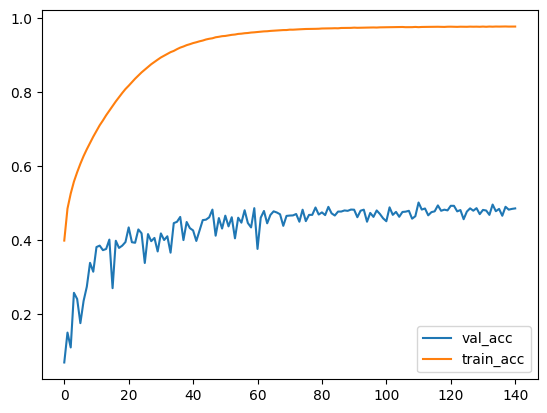

In [ ]:
plt.plot(val_acc_history,label='val_acc')
plt.plot(train_acc_history,label='train_acc')
plt.legend()
plt.show()

이미지 한개 분석 코드